# #2. SparsePCA & Clustering 
* Sparse PCA 를 통해 데이터를 차원축소하고, Clustering 을 통해 구별 target 후보지를 선정하는 과정입니다. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time
 
from geoband.API import *
import geopandas as gpd

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display

# Clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA 

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import metrics
from scipy.spatial.distance import cdist

# ANOVA Test 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'
plt.rc('axes', unicode_minus=False)

Using Python-MIP package version 1.5.3


In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [3]:
bus = pd.read_excel(current_path+'/busdata/bus_final.xlsx')
bus = bus.drop(['초미세먼지상관관계'], axis = 1)

In [4]:
# '구'변수 만들기
df_01_name=df_01[['정류장ID',"위치(동)"]]
bus_gu=bus.merge(df_01_name,how="left",left_on="정류소ID",right_on="정류장ID").drop(['정류장ID'], axis=1)

a=["경기도 수원시 파장동","경기도 수원시 율천동","경기도 수원시 정자1동","경기도 수원시 정자2동","경기도 수원시 정자3동","경기도 수원시 영화동","경기도 수원시 송죽동","경기도 수원시 조원1동","경기도 수원시 조원2동","경기도 수원시 연무동"]
b=["경기도 수원시 세류1동","경기도 수원시 세류3동","경기도 수원시 세류2동","경기도 수원시 평동","경기도 수원시 서둔동","경기도 수원시 구운동","경기도 수원시 금곡동","경기도 수원시 호매실동","경기도 수원시 권선1동","경기도 수원시 권선2동","경기도 수원시 곡선동","경기도 수원시 입북동"]
c=["경기도 수원시 행궁동","경기도 수원시 매교동","경기도 수원시 매산동","경기도 수원시 고등동","경기도 수원시 화서1동","경기도 수원시 화서2동","경기도 수원시 지동","경기도 수원시 우만1동","경기도 수원시 우만2동","경기도 수원시 인계동"]

bus_gu['구'] = ["장안구" if s in a else "권선구" if s in b else "팔달구" if s in c else "영통구" for s in bus_gu["위치(동)"]]

In [5]:
# categorical 변수 더미화 
nlp_dummy = pd.get_dummies(bus_gu['nlp_cluster'])
bus_gu.drop(['nlp_cluster'], axis = 1, inplace = True)
nlp_dummy.columns = ['nlp_'+str(i) for i in range(10)]
bus_gu = pd.concat([bus_gu,nlp_dummy], axis = 1)

bus_gu[['정류소ID','정류장명']] = bus_gu[['정류소ID','정류장명']].astype('object')

In [6]:
print(bus_gu.shape)
bus_gu.head()

(516, 145)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,위치(동),구,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0,0,0,1,0,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4,4,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3,4,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7,0,0,6002.522727,-0.194810,0.402356,0.023169,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417,59.483040,21,0,10,0,0.000000,1.000000,0.000000,0,0,0,0,0,0,경기도 수원시 연무동,장안구,0,0,0,0,0,0,0,0,1,0
1,200000008,문암골,0,0,0,1,0,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1,0,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1,0,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0,0,0,634.666667,-0.206834,0.225646,0.040863,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667,63.382027,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,경기도 수원시 연무동,장안구,0,0,0,0,0,0,0,0,1,0
2,200000036,풍림아파트입구,1,0,0,1,0,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1,0,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1,0,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0,0,0,399.000000,-0.013023,0.087172,0.058419,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.3458

In [7]:
bus_gu.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 515
Data columns (total 145 columns):
 #   Column              Dtype  
---  ------              -----  
 0   정류소ID               object 
 1   정류장명                object 
 2   쉘터                  int64  
 3   LED                 int64  
 4   LCD                 int64  
 5   LED+LCD복합형          int64  
 6   알뜰형                 int64  
 7   lon                 float64
 8   lat                 float64
 9   중앙차로여부              int64  
 10  운행노선수               int64  
 11  정류장유형수              int64  
 12  초승_환승비율             float64
 13  초승_승차비율             float64
 14  초승_하차비율             float64
 15  환승_승차비율             float64
 16  환승_하차비율             float64
 17  승차_하차비율             float64
 18  승차비율                float64
 19  환승비율                float64
 20  하차비율                float64
 21  전체 승차 건수            float64
 22  초승 건수               float64
 23  환승 건수               float64
 24  전체 하차 건수            float64
 25

# 1. 장안구 

In [8]:
bus_ja = bus_gu[bus_gu['구']=='장안구']
print(bus_ja.shape)

# 변수 제거 : 정류소ID, 정류장명, lon, lat, 구, 위치(동)
bus1 = bus_ja.drop(['정류소ID', '정류장명','lon','lat','구','위치(동)','전체승하차건수'], axis = 1)
bus1['전체승하차건수'] = bus1['전체 승차 건수'] + bus1['환승 건수']
bus_cat = bus1.select_dtypes(include = [object])
bus_num = bus1.select_dtypes(exclude = [object])

bus_num = bus_num.reset_index(drop = True)

# Standardize data
bus_std = StandardScaler().fit_transform(bus_num)

(81, 145)


## SparsePCA 

In [9]:
spca = SparsePCA(alpha = 5.79593, random_state = 2021)
%time  spca = spca.fit_transform(bus_std)
explained_variance = np.var(spca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

CPU times: user 3.37 s, sys: 6.34 s, total: 9.71 s
Wall time: 10.2 s


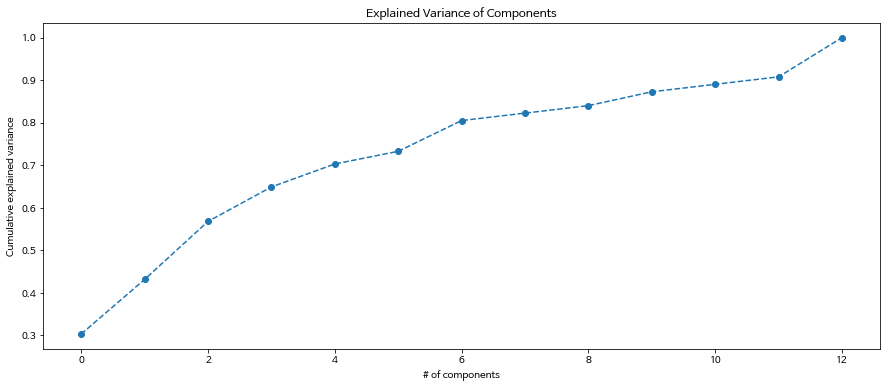

In [10]:
# cumulative variance plot 
plt.figure(figsize = (15,6))
plt.plot(range(0,np.cumsum([e for e in explained_variance_ratio if e !=0]).shape[0]), 
         np.cumsum([e for e in explained_variance_ratio if e !=0]), marker = 'o', linestyle = '--')

plt.title('Explained Variance of Components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [11]:
spca = SparsePCA(n_components = 3, alpha = 5.79593, random_state=2021)
principlecomponents = spca.fit_transform(bus_std)

spca_columns = ['spca_component_'+ str(x+1) for x in range(0,3)]
bus_spca = pd.DataFrame(principlecomponents, columns = spca_columns)

print("variance ratio : ", np.var(principlecomponents, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0])[3])

variance ratio :  [16.95802315  7.17249375  4.52517455]
culmulative variance ratio at SPC3 component :  0.6488089214545185


In [12]:
spca_components = pd.DataFrame(spca.components_, columns = list(bus_num.columns))
spca_components

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251362,0.248280,0.241512,0.244193,0.085551,0.227681,0.236916,0.245300,0.243242,0.228792,0.071537,0.242229,0.244823,0.226902,0.244758,0.224446,0.250666,0.245413,0.248245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382377,0.000000,-0.313739,0.369176,0.000000,0.000000,0.000000,0.000000,0.392364,0.335297,0.369254,0.390486,0.252713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [13]:
# SPCA축의 가장 중요한 변수
n_pcs= spca.components_.shape[0]
most_important = [np.abs(spca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = bus_num.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())
df.columns = ['spca','element']
df['value']=None
for i in range(len(df)):
    a = df['element'][i]
    df['value'][i] = spca_components[a][i]
    
df

,spca,element,value
0,PC1,유동인구_전체,0.251362
1,PC2,미세_봄,0.392364
2,PC3,초미세먼지(㎍/㎥),-0.508261


## K-means Clustering 

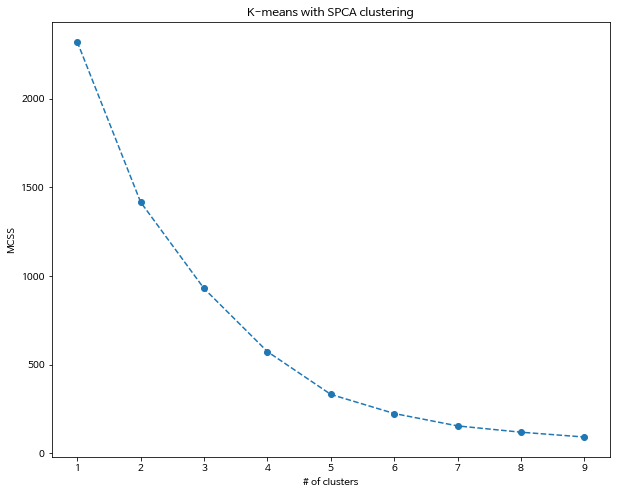

In [14]:
# K-means Clustering 
wcss = []
for i in range(1,10):
    kmeans_spca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_spca.fit(principlecomponents)
    wcss.append(kmeans_spca.inertia_)
    
# 최적의 Cluster 개수 찾기 (elbow point)
plt.figure(figsize = (10,8))
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('# of clusters')
plt.ylabel('MCSS')
plt.title('K-means with SPCA clustering')
plt.show()

In [15]:
kmeans_spca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans_spca.fit(principlecomponents)

bus_num['kmeans'] = kmeans_spca.labels_

bus_kmeans_spca = pd.concat([bus_num, bus_spca], axis = 1)
bus_kmeans_spca.head(3)

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3
0,0,0,0,1,0,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4,4,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3,4,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7,0,0,6002.522727,-0.194810,0.402356,0.023169,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417,59.483040,21,0,10,0,0.000000,1.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,644.203341,2,-2.105224,8.766267,-4.506900
1,0,0,0,1,0,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1,0,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1,0,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0,0,0,634.666667,-0.206834,0.225646,0.040863,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667,63.382027,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,77.797260,2,-2.007632,8.766267,-4.506900
2,1,0,0,1,0,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1,0,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1,0,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0,0,0,399.000000,-0.013023,0.087172,0.058419,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500,69.235167,60.162500,

In [16]:
color_list = {0:"crimson", 1:"orange", 2:"green", 3:"royalblue", 4: "purple", 5: "dimgrey", 6: "gold"}

def ClusteringPlot(loc, n_clusters, color_list) : 
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    color_list = {n:c for n,c in color_list.items() if n < n_clusters}
    ax.scatter(bus_kmeans_spca['spca_component_1'], bus_kmeans_spca['spca_component_2'], bus_kmeans_spca['spca_component_3'],
               s=60, c = bus_kmeans_spca['kmeans'].apply(lambda x: color_list[x]))
    
    # label the axes
    plt.title(f'{loc} spca & K-means Clustering', fontsize = 15, loc = 'left')
    ax.set_xlabel("SPC1")
    ax.set_ylabel("SPC2")
    ax.set_zlabel("SPC3")
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_list.values()]
    plt.legend(markers, color_list.keys(), numpoints=1,loc = 'best', bbox_to_anchor = (1.2,0.5))
    plt.show()

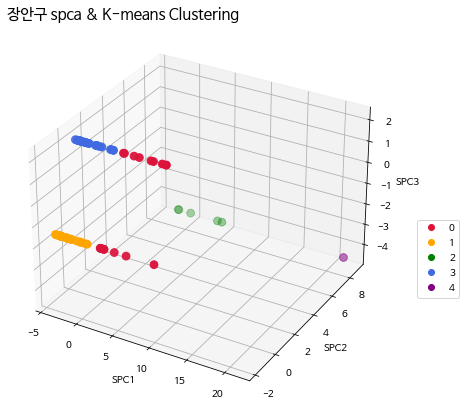

In [17]:
ClusteringPlot("장안구", 5, color_list)

In [18]:
# kmeans group 
group0 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 0]
group1 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 1]
group2 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 2]
group3 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 3]
group4 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 4]

group0.shape, group1.shape, group2.shape, group3.shape, group4.shape

((18, 143), (28, 143), (5, 143), (29, 143), (1, 143))

In [19]:
'''
PC1 : 유동인구_전체, pop_평일, 유동인구_출퇴근, 디지털정보지수, pop_주말
PC2 : 미세_봄, 미세_겨울, 미세먼지(㎍/㎥), 미세_가을, 이산화질소(ppm), 미세_여름, 초미세_봄
PC3 : 초미세_여름, 초미세_가을, 초미세_겨울, 아황산가스(ppm), 일산화탄소(ppm), 초미세먼지(㎍/㎥) 
'''

# PC1 
spca_components.iloc[0].sort_values(ascending=False)

유동인구_전체              0.251362
pop_평일               0.250666
유동인구_출퇴근             0.248280
디지털정보지수              0.248245
pop_주말               0.245413
남자40대유동인구            0.245300
여자30대유동인구            0.244823
여자50대유동인구            0.244758
유동인구_퇴근              0.244193
남자50대유동인구            0.243242
여자20대유동인구            0.242229
유동인구_출근              0.241512
남자30대유동인구            0.236916
남자60대유동인구            0.228792
남자20대유동인구            0.227681
여자40대유동인구            0.226902
여자60대유동인구            0.224446
남자10대유동인구            0.085551
여자10대유동인구            0.071537
노선유형_직행좌석형시내버스       0.007745
평균주말배차간격             0.000000
주말대기시간노출도            0.000000
주중환승비율               0.000000
주말환승많은버스             0.000000
주중승차비율               0.000000
주중배차간격(분)            0.000000
주말하차많은버스             0.000000
하행버스정류장운행시간          0.000000
주중하차비율               0.000000
주말배차간격_15분           0.000000
주말전체승하차건수            0.000000
주중환승많은버스             0.000000
주말하차비율               0.000000
주말환승비율    

In [20]:
def CompareGroups(target, n_clusters, color_list) : 
    
    '''
    ANOVA Test : 그룹 간의 평균의 차이가 유의미한지 검정
    Box Plot : 그룹 간의 차이 시각화 
    '''
    
    # ANOVA Test 
    anovamodel = ols(f'{target} ~ C(kmeans)', bus_kmeans_spca[['kmeans', target, 'spca_component_1', 'spca_component_2', 'spca_component_3']]).fit()
    print(anova_lm(anovamodel), "\n")
    
    # Box Plot 
    color_list = {n:c for n,c in color_list.items() if n < n_clusters}
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='kmeans', y=target, 
                data=bus_kmeans_spca[['kmeans', target, 'spca_component_1', 'spca_component_2', 'spca_component_3']]
               ,palette=color_list)

    plt.show()

                 df      sum_sq     mean_sq         F   PR(>F)
C(kmeans)  4.000000 7825.149621 1956.287405 83.463729 0.000000
Residual  76.000000 1781.346762   23.438773       nan      nan 



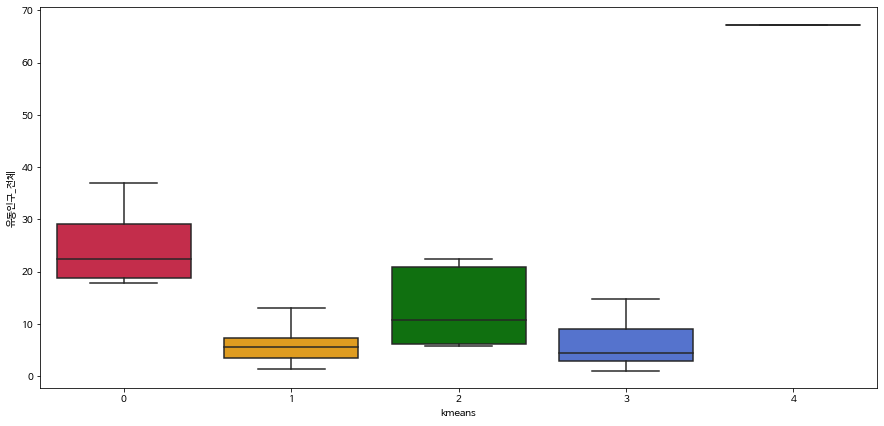

In [21]:
CompareGroups('유동인구_전체', 5, color_list) 

### 평균값을 통해 그룹 간의 차이 확인 

In [23]:
def groups5(columns) : 
    result = {}  
    
    for col in columns : 
        result[col] = [group0.mean()[col], group1.mean()[col], group2.mean()[col], group3.mean()[col], group4.mean()[col]]
    
    result = pd.DataFrame(result)
    result.index = ["group0", "group1", "group2", "group3", "group4"]
    
    return result

In [25]:
groups5(["유동인구_전체", "pop_평일", "유동인구_출퇴근", "디지털정보지수", "pop_주말", "미세_봄", "초미세먼지(㎍/㎥)"])

,유동인구_전체,pop_평일,유동인구_출퇴근,디지털정보지수,pop_주말,미세_봄,초미세먼지(㎍/㎥)
group0,24.355642,604.086565,33.760123,278.324698,536.270046,49.583333,22.687500
group1,5.908514,149.691917,8.562510,66.094263,122.249732,48.000000,23.125000
group2,13.199757,316.164967,18.314556,141.769423,318.465917,61.000000,24.166667
group3,6.083624,153.571316,8.656911,70.770785,127.305603,51.166667,22.250000
group4,67.300278,1662.529333,100.477639,712.880403,1499.645833,61.000000,24.166667


## Result 
* target : **group4** (1개, 유동인구 월등히 높음, 미세먼지 많음) + **group1** (28개, 디지털정보지수 낮음)

In [24]:
bustarget_ja = pd.concat([bus_ja[['정류소ID','정류장명','lon','lat','위치(동)']].reset_index(drop=True), bus_kmeans_spca.reset_index(drop=True)], axis = 1)
bustarget_ja = pd.concat([bustarget_ja[bustarget_ja['kmeans']==1], bustarget_ja[bustarget_ja['kmeans']==4]]).reset_index(drop=True)
bustarget_ja.to_excel(current_path+'/busdata/bustarget_jangan.xlsx', index = False)

print(bustarget_ja.shape)
bustarget_ja.head(2)

(29, 148)


,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3
0,200000036,풍림아파트입구,126.995257,37.297929,경기도 수원시 정자3동,1,0,0,1,0,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1,0,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1,0,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0,0,0,399.000000,-0.013023,0.087172,0.058419,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500,69.235167,60.162500,32.321112,0,41,331,49,0.097387,0.786223,0.116390,1,0,3,8,35,4,0,0,0,1,0,0,0,0,0,0,79.597260,1,-3.204142,-1.767409,-1.433012
1,200000047,조원뉴타운,127.018224,37.304523,경기도 수원시 조원1동,1,1,0,0,0,0,6,1,36.497205,0.946993,0.431286,0.053007,0.011793,0.443079,0.245771,0.008576,0.745654,114.020139,112.530004,1.490135,119.902309,0,0,0,6,0,0,0,0,4,17.833333,18.500000,132.583333,0.246525,0.008104,0.745371,268.569520,1,4,135.626170,0,0,4,2365.434593,32.500000,134.833333,0.245762,0.010511,0.743727,161.905421,0,4,95.186610,0,0,4,2042.795010,35.000000,0.202474,0.007174,0.790351,137.177778,0,0,4,1663.419192,-0.034233,0.050548,0.078566,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,2001,84,7,39450,467,193.400000,142.700000,0.800000,49.980000,13.140000,29.305000,3.506042,4.534722,2.960833,6.108611,4.225833,4.836667,6.171667,10.119167,11.035833,9.412500,4.180000,4.864167,5.212500,8.629167,8.676667,6.777500,82.314500,88.728333,41.475248,0,0,8,0,0.000000,1.000000,0.000000,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,115.510274,1,-2.945649,-1.767409,-1.433012


# 2. 권선구

In [25]:
bus_gs = bus_gu[bus_gu['구']=='권선구']
print(bus_gs.shape)

# 변수 제거 : 정류소ID, 정류장명, lon, lat, 구, 위치(동)
bus1 = bus_gs.drop(['정류소ID', '정류장명','lon','lat','구','위치(동)'], axis = 1)
bus_cat = bus1.select_dtypes(include = [object])
bus_num = bus1.select_dtypes(exclude = [object])

bus_num = bus_num.reset_index(drop = True)

# Standardize data
bus_std = StandardScaler().fit_transform(bus_num)

(150, 145)


## SparsePCA

In [26]:
spca = SparsePCA(ridge_alpha = .00001, alpha = 8.615, random_state = 2021)
%time  spca = spca.fit_transform(bus_std)
explained_variance = np.var(spca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

CPU times: user 2.34 s, sys: 4.43 s, total: 6.77 s
Wall time: 7.1 s


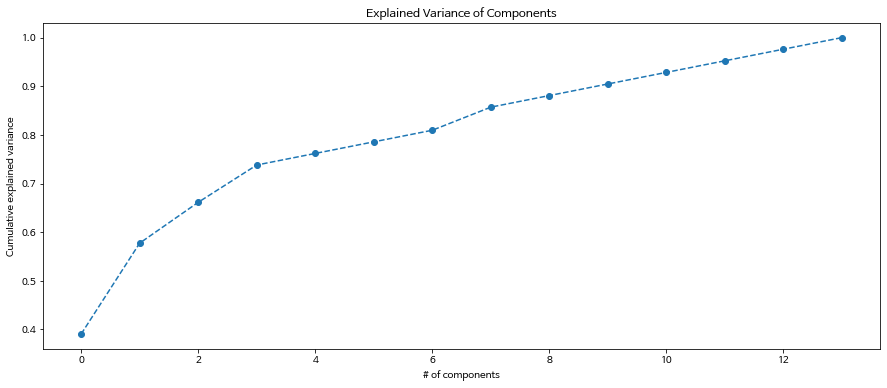

In [27]:
# decide how many features we'd like to keep based on the cumulative variance plot
plt.figure(figsize = (15,6))
plt.plot(range(0,np.cumsum([e for e in explained_variance_ratio if e !=0]).shape[0]), 
         np.cumsum([e for e in explained_variance_ratio if e !=0]), marker = 'o', linestyle = '--')
plt.title('Explained Variance of Components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [28]:
spca = SparsePCA(n_components = 3, ridge_alpha = .0001, alpha = 8.615, random_state=2021)
principlecomponents = spca.fit_transform(bus_std)

spca_columns = ['spca_component_'+ str(x+1) for x in range(0,3)]
bus_spca = pd.DataFrame(principlecomponents, columns = spca_columns)

print("variance ratio : ", np.var(principlecomponents, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0])[3])

variance ratio :  [17.8190453   7.84239779  3.57381382]
culmulative variance ratio at SPC3 component :  0.7380276815413762


In [29]:
spca_components = pd.DataFrame(spca.components_, columns = list(bus_num.columns))
spca_components

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251448,0.243837,0.237996,0.239424,0.161514,0.208519,0.235299,0.234749,0.233422,0.241100,0.151117,0.189106,0.239235,0.238612,0.241041,0.241633,0.249895,0.239800,0.247975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.354170,0.000000,0.356035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.350507,0.000000,0.353759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.354634,0.000000,0.354618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.352763,0.000000,0.351910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.449343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.520121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [30]:
# SPCA축의 가장 중요한 변수
n_pcs= spca.components_.shape[0]
most_important = [np.abs(spca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = bus_num.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())
df.columns = ['spca','element']
df['value']=None
for i in range(len(df)):
    a = df['element'][i]
    df['value'][i] = spca_components[a][i]
    
df

,spca,element,value
0,PC1,유동인구_전체,0.251448
1,PC2,하차비율,0.356035
2,PC3,주말배차간격_60분,0.538980


## K-means Clustering 

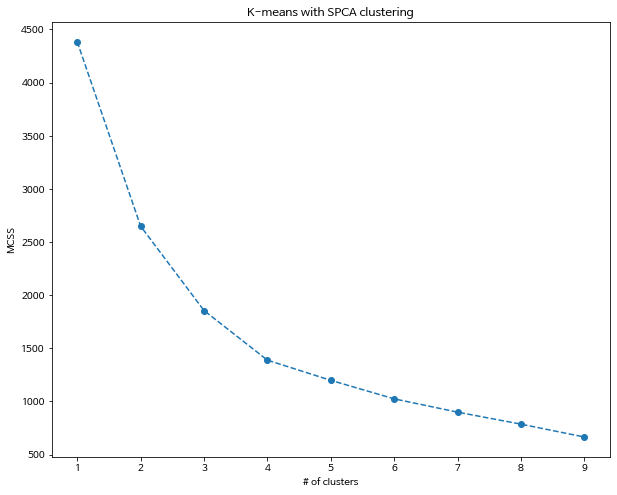

In [31]:
# K-means Clustering 
wcss = []
for i in range(1,10):
    kmeans_spca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_spca.fit(principlecomponents)
    wcss.append(kmeans_spca.inertia_)
    
# 최적의 Cluster 개수 찾기 (elbow point)
plt.figure(figsize = (10,8))
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('# of clusters')
plt.ylabel('MCSS')
plt.title('K-means with SPCA clustering')
plt.show()

In [32]:
kmeans_spca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_spca.fit(principlecomponents)

bus_num['kmeans'] = kmeans_spca.labels_

bus_kmeans_spca = pd.concat([bus_num, bus_spca], axis = 1)
bus_kmeans_spca.head(3)

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,kmeans,spca_component_1,spca_component_2,spca_component_3
0,1,0,0,1,0,0,5,1,9.923279,0.892420,0.347030,0.107580,0.043335,0.390365,0.205884,0.024806,0.769310,7.184505,6.586525,0.597980,57.691223,0,0,0,3,0,1,64.875729,0,0,2,17.666667,17.750000,13.125000,0.212377,0.026622,0.761001,73.052052,3,0,337.818668,0,0,2,98.732999,17.500000,16.875000,0.179505,0.017873,0.802622,47.551325,2,0,281.659840,0,0,2,77.779467,26.000000,0.143377,0.026491,0.830132,41.335668,0,0,2,58.870215,0.010240,0.292550,-0.077294,42.291667,22.250000,0.027917,0.025750,0.002792,0.454167,0,3954133,51.166667,32.333333,34.666667,51.000000,25.833333,15.500000,16.166667,31.500000,2001,59,21,31500,525,447.426667,321.060000,2.760000,123.606667,30.846667,64.551667,4.110278,5.509722,4.360278,6.659167,4.401667,6.755833,7.010000,10.096667,12.254167,10.802500,4.420000,6.510000,6.558333,10.057500,11.445833,8.325833,100.078000,95.213333,46.863475,0,0,0,0,0.000000,0.000000,0.000000,0,0,4,16,0,4,0,0,0,0,0,0,0,0,1,0,3,-3.334891,2.738671,-1.067663
1,1,0,0,1,0,0,6,1,6.343893,0.833261,0.324659,0.166739,0.049623,0.374281,0.220196,0.034176,0.745628,147.361931,127.131703,20.230228,355.525642,0,0,0,4,1,1,502.887573,0,0,1,19.000000,18.250000,16.666667,0.226204,0.035658,0.738138,575.574297,4,0,519.597619,0,0,1,1907.040161,30.000000,26.083333,0.197094,0.029242,0.773664,349.871606,2,1,387.725342,0,0,1,1406.972285,70.000000,0.192142,0.027181,0.780677,311.944444,0,0,2,1197.055556,-0.031441,0.030764,0.101967,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,0,3954133,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,1994,81,2,26100,319,2191.615000,1806.860000,30.330000,354.425000,99.207500,99.770000,8.482049,12.261528,10.650278,13.872778,3.827500,14.500833,24.199167,27.878333,30.286667,26.035833,2.988333,10.668333,13.315000,16.935833,17.982500,14.960833,215.225500,174.486667,91.025779,0,0,0,0,0.000000,0.000000,0.000000,0,1,3,15,4,11,0,0,0,0,0,0,0,0,1,0,3,-2.260519,2.430210,-0.715820
2,1,0,0,1,0,0,4,1,11.967204,0.918247,0.621245,0.081753,0.057043,0.678288,0.366108,0.033234,0.600658,92.698630,84.257534,8.441096,136.506849,0,0,0,3,1,0,229.205479,0,0,0,18.583333,18.250000,14.875000,0.363106,0.033768,0.603126,262.787149,3,0,382.085714,0,0,0,1183.174699,30.000000,27.750000,0.381248,0.032044,0.586709,158.278846,2,1,282.932331,0,0,0,1040.711538,70.000000,0.355049,0.026568,0.618384,144.333333,0,0,0,851.611111,-0.045846,0.017782,0.073465,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,0,3954133,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,1989,54,3,12400,225,2213.520000,1824.500000,30.780000,358.220000,99.427500,99.820000,8.743125,12.410972,10.845000,13.976944,4.304167,13.515833,25.495000,29.760000,30.930000,25.610000,3.535833,10.754167,15.447500,18.638333,18.24

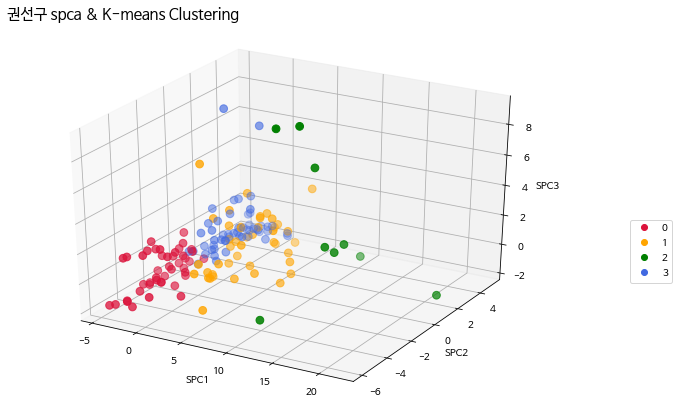

In [33]:
ClusteringPlot("권선구", 4, color_list)

In [34]:
# kmeans group 
group0 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 0]
group1 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 1]
group2 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 2]
group3 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 3]

group0.shape, group1.shape, group2.shape, group3.shape

((44, 143), (44, 143), (9, 143), (53, 143))

In [35]:
'''
0 : (+) 유동인구_전체, pop_평일, 디지털정보지수, 유동인구... 
1 : (+) 하차비율 / (-) 승차비율
2 : (+) 주말배차간격_60분, 노선유형_일반형시내버스, 주중배차간격_60분, 운행노선수

'''

# PC1 
spca_components.iloc[0].sort_values(ascending=False)

유동인구_전체              0.251448
pop_평일               0.249895
디지털정보지수              0.247975
유동인구_출퇴근             0.243837
여자60대유동인구            0.241633
남자60대유동인구            0.241100
여자50대유동인구            0.241041
pop_주말               0.239800
유동인구_퇴근              0.239424
여자30대유동인구            0.239235
여자40대유동인구            0.238612
유동인구_출근              0.237996
남자30대유동인구            0.235299
남자40대유동인구            0.234749
남자50대유동인구            0.233422
남자20대유동인구            0.208519
여자20대유동인구            0.189106
남자10대유동인구            0.161514
여자10대유동인구            0.151117
주말대기시간노출도            0.000000
주말하차많은버스             0.000000
주말배차간격(분)            0.000000
주말환승많은버스             0.000000
주중환승비율               0.000000
주중승차비율               0.000000
주중배차간격(분)            0.000000
하행버스정류장운행시간          0.000000
상행버스정류장운행시간          0.000000
주말승차많은버스             0.000000
주중하차비율               0.000000
주말승차비율               0.000000
주말배차횟수               0.000000
주중배차간격_60분           0.000000
평균주중배차간격  

                  df       sum_sq      mean_sq          F   PR(>F)
C(kmeans)   3.000000 31881.342050 10627.114017 216.789123 0.000000
Residual  146.000000  7156.994890    49.020513        nan      nan 



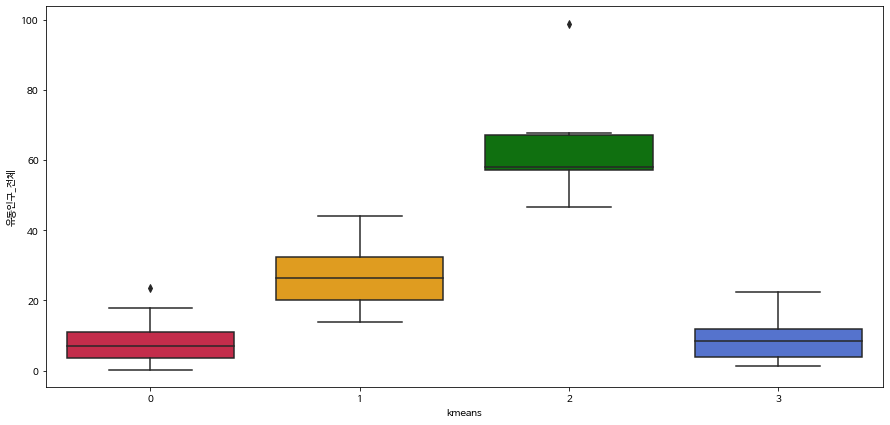

In [36]:
CompareGroups('유동인구_전체', 4, color_list) 

                  df         sum_sq        mean_sq          F   PR(>F)
C(kmeans)   3.000000 3981484.999634 1327161.666545 242.334374 0.000000
Residual  146.000000  799579.523857    5476.572081        nan      nan 



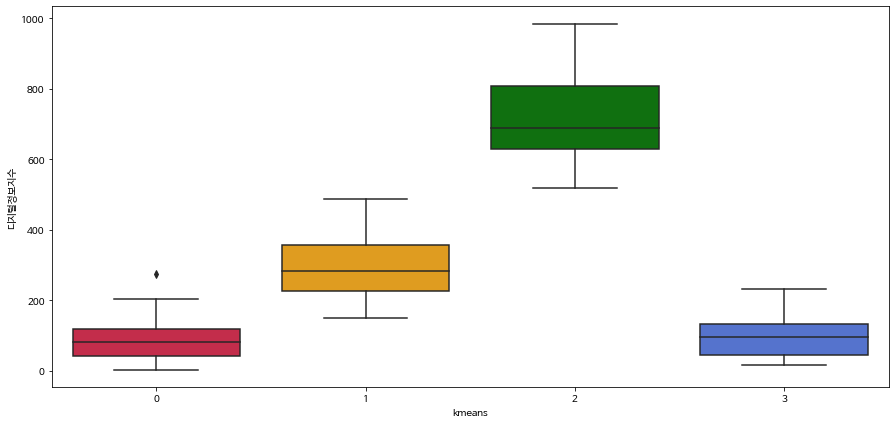

In [37]:
CompareGroups('디지털정보지수', 4, color_list) 

                  df   sum_sq  mean_sq         F   PR(>F)
C(kmeans)   3.000000 5.691642 1.897214 74.908933 0.000000
Residual  146.000000 3.697733 0.025327       nan      nan 



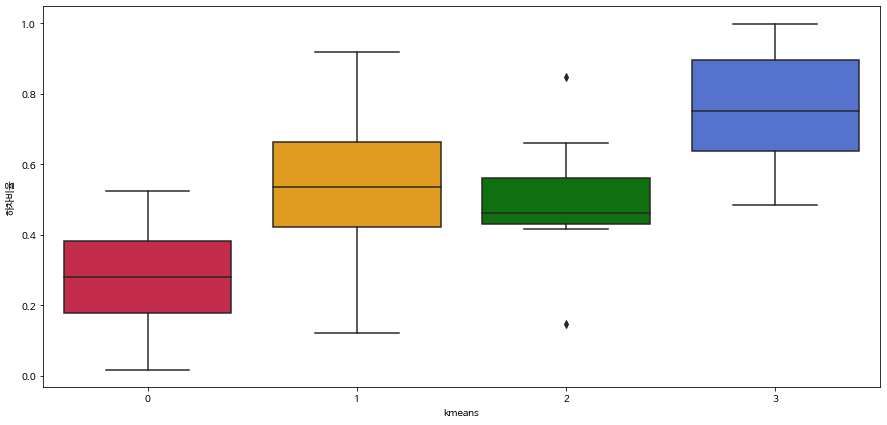

In [38]:
CompareGroups('하차비율', 4, color_list) 

### 평균값을 통해 그룹 간의 차이 확인 

In [39]:
def groups4(columns) : 
    result = {}  
    
    for col in columns : 
        result[col] = [group0.mean()[col], group1.mean()[col], group2.mean()[col], group3.mean()[col]]
    
    result = pd.DataFrame(result)
    result.index = ["group0", "group1", "group2", "group3"]
    
    return result

In [40]:
# PC1
groups4(['유동인구_전체', 'pop_평일', '유동인구_출퇴근', '디지털정보지수'])

,유동인구_전체,pop_평일,유동인구_출퇴근,디지털정보지수
group0,7.368566,186.466621,10.742102,83.081035
group1,27.186314,673.393890,39.601395,298.439057
group2,63.662747,1563.561796,88.807917,718.398933
group3,8.715326,219.524192,12.686412,98.033701


In [41]:
# PC2 
groups4(['하차비율', '승차비율', '환승비율'])

,하차비율,승차비율,환승비율
group0,0.271302,0.676932,0.051766
group1,0.524836,0.388768,0.086397
group2,0.495642,0.407765,0.096593
group3,0.757175,0.208492,0.034334


In [42]:
# PC3 
groups4(['주말배차간격_60분', '노선유형_일반형시내버스', '주중배차간격_60분', '운행노선수', '주중대기시간노출도'])

,주말배차간격_60분,노선유형_일반형시내버스,주중배차간격_60분,운행노선수,주중대기시간노출도
group0,1.250000,4.522727,0.545455,6.954545,2881.894466
group1,2.409091,6.636364,1.386364,9.886364,5228.384471
group2,7.111111,11.444444,5.444444,15.777778,6804.931273
group3,1.339623,4.641509,0.886792,6.660377,1300.472077


## Result 
* target : **group2** (9개, 유동인구 수 월등히 높음) + **group1** (44개, 유동인구 수 두 번째로 높고 하차 비율도 높음) 

In [43]:
bustarget_gs = pd.concat([bus_gs[['정류소ID','정류장명','lon','lat','위치(동)']].reset_index(drop=True), bus_kmeans_spca.reset_index(drop=True)], axis = 1)
bustarget_gs = pd.concat([bustarget_gs[bustarget_gs['kmeans']==2], bustarget_gs[bustarget_gs['kmeans']==1]]).reset_index(drop=True)
bustarget_gs.to_excel(current_path+'/busdata/bustarget_gs.xlsx', index = False)

print(bustarget_gs.shape)
bustarget_gs.head(2)

(53, 148)


,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,kmeans,spca_component_1,spca_component_2,spca_component_3
0,201000020,공구유통타운.중앙자동차매매단지,126.997100,37.258369,경기도 수원시 평동,1,1,0,0,0,0,26,2,3.191499,0.725624,3.568195,0.274376,1.687035,5.255230,0.377858,0.160318,0.461824,83.134933,61.868984,21.265948,138.931587,0,0,1,19,2,1,222.066520,2,7,1,18.500000,18.833333,106.543478,0.387849,0.163327,0.448824,260.861098,4,11,732.846779,3,6,1,2688.418030,60.000000,116.304348,0.339629,0.143684,0.516688,137.259063,2,13,565.045976,2,4,1,1986.031449,90.000000,0.347882,0.140533,0.511585,116.120098,2,5,1,1818.891136,-0.080218,0.031145,0.050613,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1999,124,1,54500,436,1522.840000,1265.671429,16.314286,240.848571,98.581429,99.538571,57.162639,97.072083,84.946111,109.198056,19.545000,94.073333,182.760000,233.745833,226.999167,164.753333,19.798333,61.578333,83.535833,105.290000,104.915833,74.906667,1499.883000,1055.893333,627.590702,0,0,0,0,0.000000,0.000000,0.000000,1,1,0,14,0,0,0,0,1,0,0,0,0,0,0,0,2,10.342302,0.001444,6.360808
1,201000023,고색역.고색초교.태산아파트,126.979930,37.250431,경기도 수원시 평동,1,1,0,0,0,0,33,3,5.755202,0.826671,2.824972,0.173329,0.740922,3.565893,0.463279,0.091232,0.445489,809.386900,686.066921,123.319978,446.915572,0,0,0,23,2,5,1256.302472,3,2,5,18.500000,18.833333,111.550000,0.449018,0.092756,0.458227,1461.035239,5,16,896.252956,3,2,5,19997.450902,60.000000,119.916667,0.509618,0.085212,0.405170,823.825276,2,18,712.173511,7,0,5,17573.532107,90.000000,0.531437,0.079581,0.388982,757.545904,8,1,4,17169.202614,-0.081422,0.014562,0.164225,39.625000,22.208333,0.023167,0.026667,0.002833,0.583333,1,3954133,43.000000,31.333333,35.333333,48.833333,24.666667,14.166667,17.000000,33.000000,1998,59,5,27800,464,1473.616667,1227.520000,14.643333,231.436667,98.485000,99.425000,46.478958,64.262222,55.865278,72.659167,34.549167,74.468333,120.438333,147.153333,155.360833,131.195833,31.093333,65.148333,73.939167,89.387500,106.790833,85.957500,1156.136833,1016.100000,516.874169,0,6,11,0,0.352941,0.647059,0.000000,0,0,3,3,0,0,0,0,0,1,0,0,0,0,0,0,2,7.599770,-1.048033,9.039972


# 3. 팔달구 

In [44]:
bus_pd = bus_gu[bus_gu['구']=='팔달구']
print(bus_pd.shape)

# 변수 제거 : 정류소ID, 정류장명, lon, lat, 구, 위치(동)
bus1 = bus_pd.drop(['정류소ID', '정류장명','lon','lat','구','위치(동)','전체승하차건수'], axis = 1)
bus1['전체승하차건수'] = bus1['전체 승차 건수'] + bus1['환승 건수']
bus_cat = bus1.select_dtypes(include = [object])
bus_num = bus1.select_dtypes(exclude = [object])

bus_num = bus_num.reset_index(drop = True)

# Standardize data
bus_std = StandardScaler().fit_transform(bus_num)

(84, 145)


## SparsePCA

In [45]:
spca = SparsePCA(alpha = 6.5, random_state = 2021)
%time  spca = spca.fit_transform(bus_std)
explained_variance = np.var(spca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

CPU times: user 1.82 s, sys: 3.2 s, total: 5.02 s
Wall time: 5.25 s


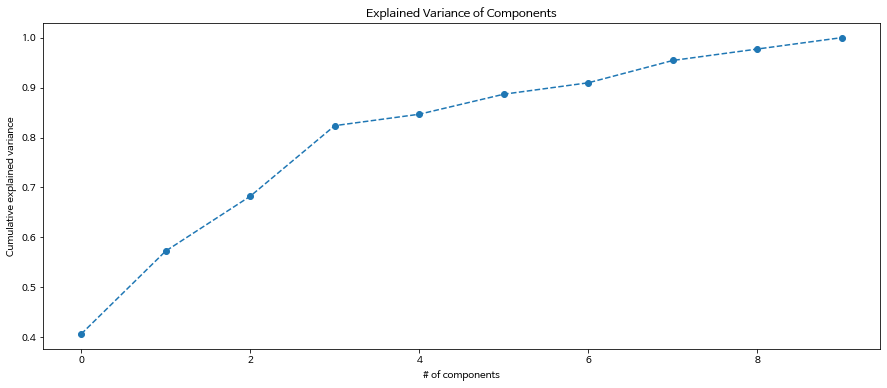

In [46]:
# cumulative variance plot 
plt.figure(figsize = (15,6))
plt.plot(range(0,np.cumsum([e for e in explained_variance_ratio if e !=0]).shape[0]), 
         np.cumsum([e for e in explained_variance_ratio if e !=0]), marker = 'o', linestyle = '--')

plt.title('Explained Variance of Components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [47]:
spca = SparsePCA(n_components = 3, alpha = 6.5, random_state=2021)
principlecomponents = spca.fit_transform(bus_std)

spca_columns = ['spca_component_'+ str(x+1) for x in range(0,3)]
bus_spca = pd.DataFrame(principlecomponents, columns = spca_columns)

print("variance ratio : ", np.var(principlecomponents, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0])[3])

variance ratio :  [17.42933216  7.12450104  7.81373353]
culmulative variance ratio at SPC3 component :  0.8237384172190313


In [48]:
spca_components = pd.DataFrame(spca.components_, columns = list(bus_num.columns))
spca_components

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.255129,-0.248183,-0.242553,-0.246054,-0.175951,-0.208720,-0.229726,-0.218616,-0.227046,-0.222941,-0.203894,-0.198268,-0.239890,-0.216856,-0.242668,-0.210528,-0.253514,-0.248517,-0.250802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.356295,0.000000,0.352605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.343451,0.000000,0.344458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.366058,0.000000,0.357769,0.000000,0.000000,0.000000,0.000000,-0.002221,0.000000,0.000000,0.000000,0.000000,-0.346787,0.000000,0.360348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [49]:
# SPCA축의 가장 중요한 변수
n_pcs= spca.components_.shape[0]
most_important = [np.abs(spca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = bus_num.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())
df.columns = ['spca','element']
df['value']=None
for i in range(len(df)):
    a = df['element'][i]
    df['value'][i] = spca_components[a][i]
    
df

,spca,element,value
0,PC1,유동인구_전체,-0.255129
1,PC2,주말승차비율,-0.366058
2,PC3,이산화질소(ppm),-0.399782


## K-means Clustering 

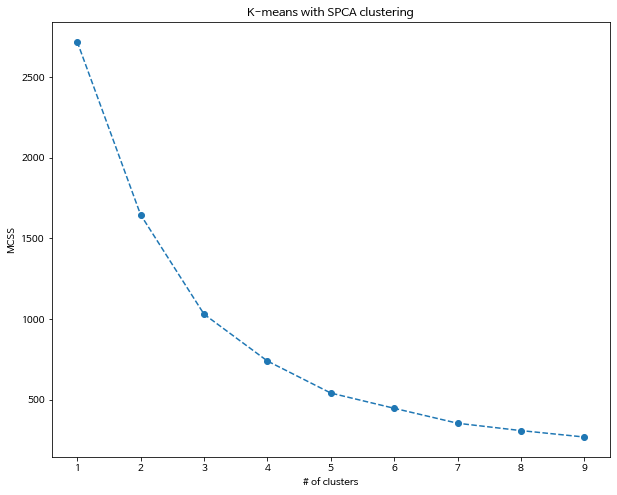

In [50]:
# K-means Clustering 
wcss = []
for i in range(1,10):
    kmeans_spca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_spca.fit(principlecomponents)
    wcss.append(kmeans_spca.inertia_)
    
# 최적의 Cluster 개수 찾기 (elbow point)
plt.figure(figsize = (10,8))
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('# of clusters')
plt.ylabel('MCSS')
plt.title('K-means with SPCA clustering')
plt.show()

In [51]:
kmeans_spca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_spca.fit(principlecomponents)

bus_num['kmeans'] = kmeans_spca.labels_

bus_kmeans_spca = pd.concat([bus_num, bus_spca], axis = 1)
bus_kmeans_spca.head(3)

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3
0,1,1,0,0,0,0,14,2,1.445271,0.483983,8.740208,0.516017,4.127307,12.867515,0.425709,0.435698,0.138593,883.719154,443.096866,440.622288,189.287514,0,0,0,10,0,1,1,10,0,18.000000,18.250000,85.545455,0.416651,0.442508,0.140841,1256.476505,4,5,577.885509,1,10,0,12191.477482,25.000000,88.909091,0.457533,0.408675,0.133792,688.255396,3,5,427.729779,1,10,0,8896.332441,45.000000,0.449617,0.403858,0.146525,597.318568,1,10,0,7764.480392,0.006811,0.211960,0.009849,42.291667,22.250000,0.027917,0.025750,0.002792,0.454167,1,3699723,51.166667,32.333333,34.666667,51.000000,25.833333,15.500000,16.166667,31.500000,1997,84,7,55000,648,1725.906667,1341.846667,20.846667,363.173333,27.410000,58.075000,33.016146,38.465417,34.523889,42.406944,40.005833,51.087500,74.631667,87.924167,89.696667,77.352500,35.759167,49.476667,65.555833,85.143333,75.472500,60.283333,785.711667,808.633750,390.290034,0,78,391,49,0.150579,0.754826,0.094595,0,0,0,2,0,3,0,0,1,0,0,0,0,0,0,0,1324.341441,3,-3.480374,-3.174432,1.744652
1,1,0,0,1,0,0,5,1,3.827397,0.792482,0.866325,0.207518,0.227554,1.093879,0.413318,0.108385,0.478297,135.810423,108.311571,27.498852,130.443981,0,0,0,3,0,0,0,0,0,17.750000,18.416667,23.500000,0.413929,0.106740,0.479331,301.150813,2,0,294.791444,0,0,0,1411.080046,55.000000,37.833333,0.411326,0.116150,0.472524,193.780000,2,1,192.610101,0,0,0,1341.294231,90.000000,0.428358,0.106404,0.465238,170.611111,0,0,0,1241.472222,0.000625,0.192887,0.010283,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,1,3872030,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1996,59,4,27000,454,1026.466667,870.653333,8.333333,147.433333,19.075000,50.520000,43.660417,71.615000,64.093333,79.136667,32.430000,97.967500,104.438333,109.963333,112.700833,132.395833,29.766667,103.295833,76.714167,75.082500,78.803333,94.298333,1056.548167,1028.362083,443.737721,0,0,0,0,0.000000,0.000000,0.000000,0,0,5,12,0,6,0,0,0,0,0,1,0,0,0,0,163.309275,2,-5.982865,-0.566526,2.389086
2,1,1,0,0,0,0,28,2,11.085505,0.912085,1.770013,0.087915,0.156013,1.926026,0.566812,0.052872,0.380316,1799.871311,1649.811187,150.060124,1117.349161,0,0,0,25,0,0,5,0,0,18.866667,19.250000,28.660000,0.576777,0.052121,0.371101,3565.577394,11,3,1755.595820,8,0,0,30438.509858,55.000000,34.100000,0.509149,0.057835,0.433016,1524.773867,8,3,1335.709665,3,0,0,14986.730925,60.000000,0.543112,0.049621,0.407267,1447.645425,4,0,0,15140.671569,-0.004580,0.081893,0.003028,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2012,84,9,38700,455,1007.340000,864.140000,8.540000,134.660000,99.665000,99.950000,19.926319,27.607639,33.471389,21.743889,6.555000,25.511667,43.295000,52.458333,55.706

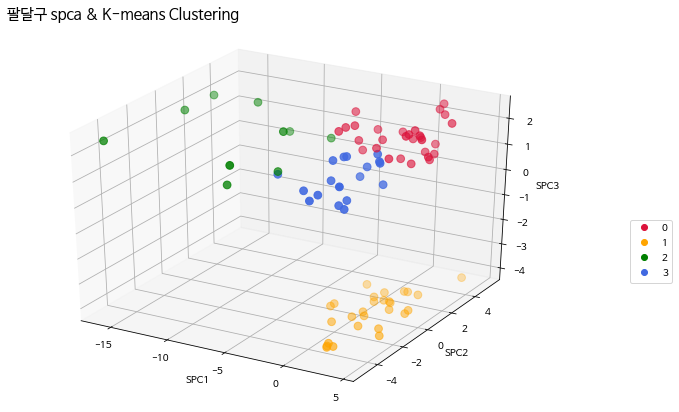

In [52]:
ClusteringPlot("팔달구", 4, color_list)

In [53]:
# kmeans group 
group0 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 0]
group1 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 1]
group2 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 2]
group3 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 3]

group0.shape, group1.shape, group2.shape, group3.shape

((29, 143), (27, 143), (10, 143), (18, 143))

In [54]:
'''
PC1 : 유동인구_전체, 디지털정보지수, 유동인구_출퇴근, 유동인구_퇴근, pop_평일, pop_주말, 성연령별유동인구, ... 
PC2 : 하차비율, 승차비율, 주말승차많은버스, ...
PC3 : 미세먼지(㎍/㎥), 이산화질소(ppm), 오존(ppm), ... 
'''

# PC1 
spca_components.iloc[0].sort_values(ascending=False)

전체승하차건수               0.000000
주중대기시간노출도             0.000000
주말전체승하차건수             0.000000
주말하차비율                0.000000
주말환승비율                0.000000
주말승차비율                0.000000
주말배차간격(분)             0.000000
평균주중배차간격              0.000000
주중하차많은버스              0.000000
주중환승비율                0.000000
주중환승많은버스              0.000000
주중승차많은버스              0.000000
주중배차횟수                0.000000
주중배차간격_60분            0.000000
주중배차간격_15분            0.000000
주중전체승하차건수             0.000000
주말배차간격_15분            0.000000
주말배차간격_60분            0.000000
주말배차횟수                0.000000
주말승차많은버스              0.000000
주말환승많은버스              0.000000
주말하차많은버스              0.000000
주말대기시간노출도             0.000000
평균주말배차간격              0.000000
공휴일승차비율               0.000000
공휴일환승비율               0.000000
공휴일하차비율               0.000000
공휴일전체승하차건수            0.000000
공휴일승차많은버스             0.000000
공휴일환승많은버스             0.000000
공휴일하차많은버스             0.000000
공휴일대기시간노출도            0.000000
강수량상관관계 

                 df       sum_sq     mean_sq         F   PR(>F)
C(kmeans)  3.000000 18498.093757 6166.031252 64.141881 0.000000
Residual  80.000000  7690.490063   96.131126       nan      nan 



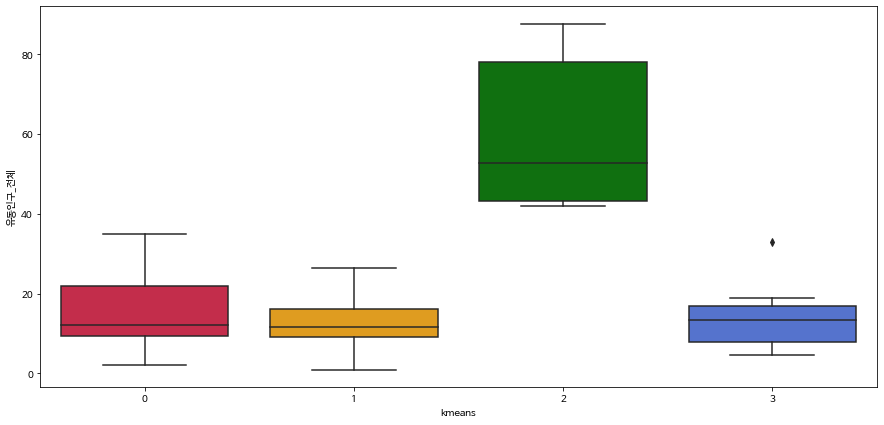

In [55]:
CompareGroups('유동인구_전체', 4, color_list) 

                 df         sum_sq       mean_sq         F   PR(>F)
C(kmeans)  3.000000 1775499.256342 591833.085447 62.648426 0.000000
Residual  80.000000  755751.577218   9446.894715       nan      nan 



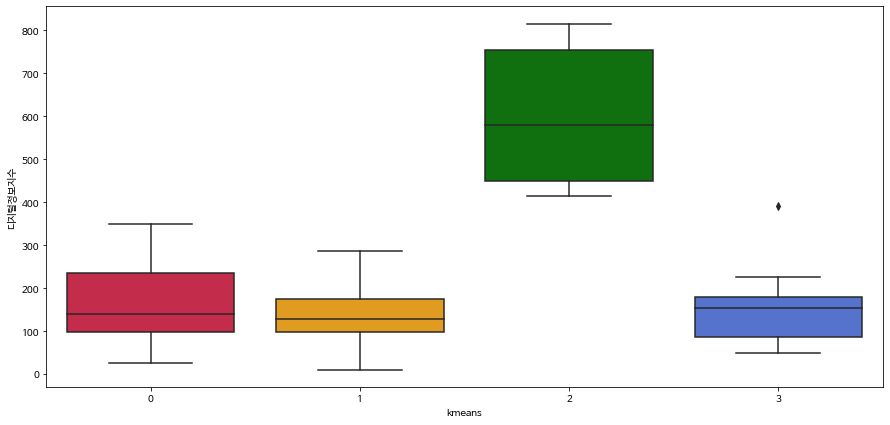

In [56]:
CompareGroups('디지털정보지수', 4, color_list) 

                 df         sum_sq        mean_sq         F   PR(>F)
C(kmeans)  3.000000 9955952.220309 3318650.740103 68.625177 0.000000
Residual  80.000000 3868726.758428   48359.084480       nan      nan 



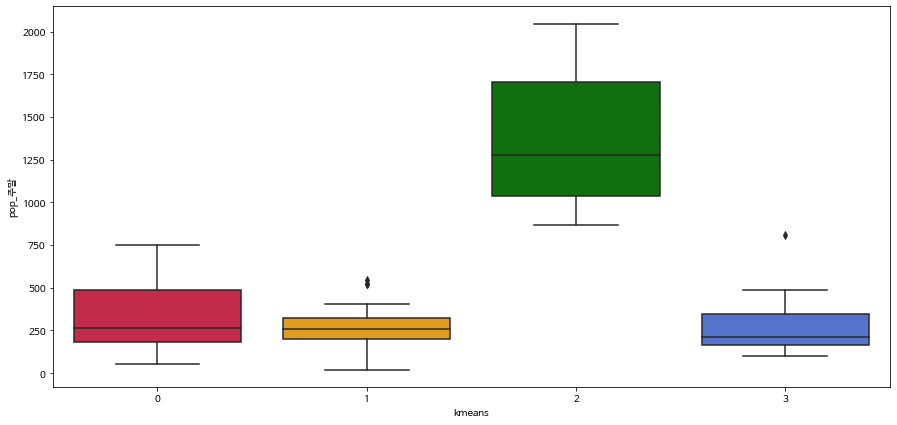

In [57]:
CompareGroups('pop_주말', 4, color_list) 

### 평균값을 통해 그룹 간의 차이 확인 

In [58]:
groups4(["유동인구_전체", "pop_평일", "디지털정보지수", "pop_주말"])

,유동인구_전체,pop_평일,디지털정보지수,pop_주말
group0,15.381653,382.204684,165.701607,337.006221
group1,12.409990,313.912605,135.974688,258.107685
group2,59.421528,1456.267850,597.524043,1352.141667
group3,13.178032,331.448111,146.536971,278.642685


In [59]:
# PC2 
groups4(["주말승차비율", "승차비율", "공휴일하차비율", "주말하차비율"])

,주말승차비율,승차비율,공휴일하차비율,주말하차비율
group0,0.237687,0.225479,0.668383,0.671791
group1,0.444767,0.429061,0.500217,0.508975
group2,0.397991,0.372266,0.423055,0.423676
group3,0.570099,0.556841,0.327261,0.334066


In [60]:
# PC3 
groups4(["이산화질소(ppm)", "미세_겨울", "오존(ppm)"])

,이산화질소(ppm),미세_겨울,오존(ppm)
group0,0.025769,49.103448,0.027152
group1,0.034458,60.833333,0.018250
group2,0.025900,48.333333,0.026650
group3,0.025877,49.240741,0.027037


## Result 
* target : **group2** (10개, 유동인구 & pop_주말 월등히 높음) + **group1** (27개, 디지털정보지수 많이 낮고 미세먼지 농도 높음)

In [61]:
bustarget_pd = pd.concat([bus_pd[['정류소ID','정류장명','lon','lat','위치(동)']].reset_index(drop=True), bus_kmeans_spca.reset_index(drop=True)], axis = 1)
bustarget_pd = pd.concat([bustarget_pd[bustarget_pd['kmeans']==2], bustarget_pd[bustarget_pd['kmeans']==1]]).reset_index(drop=True)
bustarget_pd.to_excel(current_path+'/busdata/bustarget_paldal.xlsx', index = False)

print(bustarget_pd.shape)
bustarget_pd.head(2)

(37, 148)


,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3
0,201000287,매교역4번출구.경기도박치료센터,127.015063,37.265523,경기도 수원시 매교동,1,0,0,1,0,0,5,1,3.827397,0.792482,0.866325,0.207518,0.227554,1.093879,0.413318,0.108385,0.478297,135.810423,108.311571,27.498852,130.443981,0,0,0,3,0,0,0,0,0,17.750000,18.416667,23.500000,0.413929,0.106740,0.479331,301.150813,2,0,294.791444,0,0,0,1411.080046,55.000000,37.833333,0.411326,0.116150,0.472524,193.780000,2,1,192.610101,0,0,0,1341.294231,90.000000,0.428358,0.106404,0.465238,170.611111,0,0,0,1241.472222,0.000625,0.192887,0.010283,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,1,3872030,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1996,59,4,27000,454,1026.466667,870.653333,8.333333,147.433333,19.075000,50.520000,43.660417,71.615000,64.093333,79.136667,32.430000,97.967500,104.438333,109.963333,112.700833,132.395833,29.766667,103.295833,76.714167,75.082500,78.803333,94.298333,1056.548167,1028.362083,443.737721,0,0,0,0,0.000000,0.000000,0.000000,0,0,5,12,0,6,0,0,0,0,0,1,0,0,0,0,163.309275,2,-5.982865,-0.566526,2.389086
1,202000011,중소기업은행,127.033395,37.266237,경기도 수원시 인계동,1,0,0,1,0,0,13,1,4.286277,0.788806,0.401787,0.211194,0.112779,0.514566,0.232416,0.066355,0.701230,809.212526,640.270891,168.941635,1112.889704,0,0,0,7,0,3,0,0,3,19.000000,18.750000,22.350000,0.232281,0.069324,0.698395,2209.304947,4,0,741.822564,0,0,3,9868.925673,45.000000,30.350000,0.234740,0.055074,0.710185,1322.453030,3,2,531.029322,0,0,3,8042.133984,72.500000,0.229927,0.053895,0.716178,1122.005983,0,0,4,6734.994925,-0.043330,0.094638,0.061255,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,1,3576596,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,2014,15,9,7800,519,1575.224000,1323.068000,16.392000,235.732000,33.020000,67.493000,56.932292,75.897222,56.370000,95.424444,36.202500,115.939167,162.910833,178.048333,146.736667,114.762500,42.260833,103.095833,121.162500,151.446667,113.317500,80.479167,1311.896167,1503.891667,630.778358,0,0,101,0,0.000000,1.000000,0.000000,1,1,0,33,0,0,0,0,0,0,0,0,0,0,1,0,978.154162,2,-8.997537,2.574102,1.267798


# 4. 영통구 

In [62]:
bus_yt = bus_gu[bus_gu['구']=='영통구']
print(bus_yt.shape)

# 변수 제거 : 정류소ID, 정류장명, lon, lat, 구, 위치(동)
bus1 = bus_yt.drop(['정류소ID', '정류장명','lon','lat','구','위치(동)','전체승하차건수'], axis = 1)
bus1 = bus1.rename(columns = {'전체 승차 건수' : '전체승차건수'})
bus_cat = bus1.select_dtypes(include = [object])
bus_num = bus1.select_dtypes(exclude = [object])

bus_num = bus_num.reset_index(drop = True)

# Standardize data
bus_std = StandardScaler().fit_transform(bus_num)

(201, 145)


## SPCA 

In [63]:
spca = SparsePCA(ridge_alpha = 0.001, alpha = 9, random_state = 2021)
%time  spca = spca.fit_transform(bus_std)
explained_variance = np.var(spca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

CPU times: user 3.02 s, sys: 5.27 s, total: 8.29 s
Wall time: 8.79 s


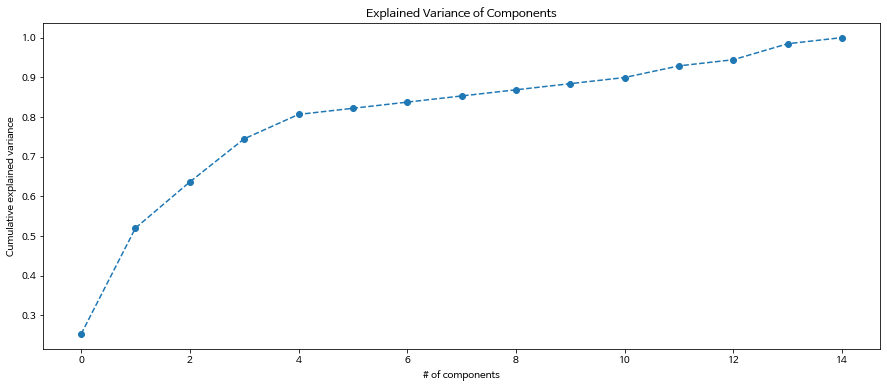

In [64]:
# cumulative variance plot 
plt.figure(figsize = (15,6))
plt.plot(range(0,np.cumsum([e for e in explained_variance_ratio if e !=0]).shape[0]), 
         np.cumsum([e for e in explained_variance_ratio if e !=0]), marker = 'o', linestyle = '--')

plt.title('Explained Variance of Components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [65]:
spca = SparsePCA(n_components = 3, ridge_alpha = 0.001, alpha = 9, random_state=2021)
principlecomponents = spca.fit_transform(bus_std)

spca_columns = ['spca_component_'+ str(x+1) for x in range(0,3)]
bus_spca = pd.DataFrame(principlecomponents, columns = spca_columns)

print("variance ratio : ", np.var(principlecomponents, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0])[3])

variance ratio :  [16.23379713 17.19830692  7.47925248]
culmulative variance ratio at SPC3 component :  0.7447646971093937


In [66]:
spca_components = pd.DataFrame(spca.components_, columns = list(bus_num.columns))
spca_components

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체승차건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.176611,0.000000,0.000000,0.048527,0.000000,-0.048527,0.000000,0.000000,0.000000,-0.111354,0.000000,-0.297704,-0.165814,-0.238025,-0.164871,0.000000,0.000000,0.000000,-0.144760,0.000000,0.000000,0.000000,-0.180805,0.000000,0.000000,0.000000,0.000000,0.000000,-0.106755,0.000000,-0.302265,-0.156905,0.000000,-0.175208,0.000000,-0.172031,0.000000,-0.284331,0.000000,0.000000,0.000000,-0.125372,0.000000,-0.286865,-0.071699,0.000000,-0.172851,0.000000,-0.143025,0.000000,-0.277337,0.000000,0.000000,-0.121271,0.000000,-0.288628,0.000000,-0.143463,0.000000,-0.283871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.256533,-0.247410,-0.234456,-0.249532,-0.207944,-0.239235,-0.147501,-0.148792,-0.237866,-0.223068,-0.209392,-0.239734,-0.241395,-0.246962,-0.238030,-0.216505,-0.245197,-0.236707,-0.254501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360131,0.000000,-0.359725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [67]:
# SPCA축의 가장 중요한 변수
n_pcs= spca.components_.shape[0]
most_important = [np.abs(spca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = bus_num.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())
df.columns = ['spca','element']
df['value']=None
for i in range(len(df)):
    a = df['element'][i]
    df['value'][i] = spca_components[a][i]
    
df

,spca,element,value
0,PC1,주중전체승하차건수,-0.302265
1,PC2,유동인구_전체,-0.256533
2,PC3,주말승차비율,0.360507


## K-means Clustering 

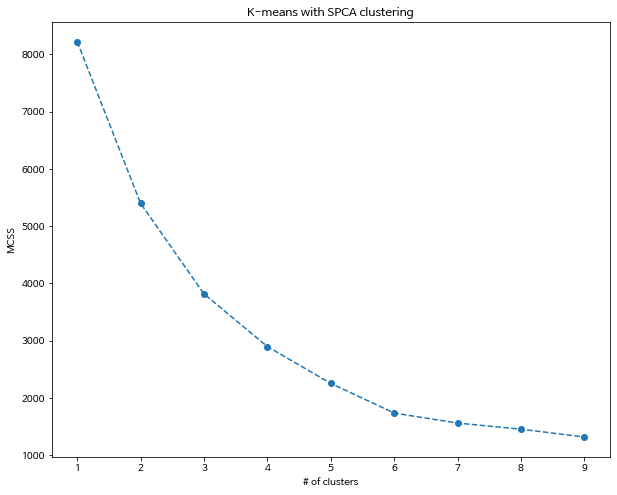

In [68]:
# K-means Clustering 
wcss = []
for i in range(1,10):
    kmeans_spca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_spca.fit(principlecomponents)
    wcss.append(kmeans_spca.inertia_)
    
# 최적의 Cluster 개수 찾기 (elbow point)
plt.figure(figsize = (10,8))
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('# of clusters')
plt.ylabel('MCSS')
plt.title('K-means with SPCA clustering')
plt.show()

In [69]:
kmeans_spca = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
kmeans_spca.fit(principlecomponents)

bus_num['kmeans'] = kmeans_spca.labels_

bus_kmeans_spca = pd.concat([bus_num, bus_spca], axis = 1)
bus_kmeans_spca.head(3)

,쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체승차건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,kmeans,spca_component_1,spca_component_2,spca_component_3
0,0,0,0,1,0,0,24,1,1.794122,0.594773,0.386767,0.405227,0.249886,0.636653,0.138967,0.091070,0.769963,343.380656,209.762169,133.618487,1040.397294,0,0,0,14,0,6,0,2,9,18.833333,18.666667,32.225000,0.138455,0.092696,0.768849,1539.122663,6,3,1236.928799,0,1,9,4822.770277,45.000000,39.600000,0.141659,0.087622,0.770719,1060.196884,1,4,894.930975,0,1,10,4528.199096,65.000000,0.139955,0.086732,0.773314,914.450630,0,1,10,3905.249125,-0.039862,0.068843,0.088974,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,1995,59,8,30000,505,614.765000,521.735000,3.885000,89.185000,39.185000,68.142500,13.885312,19.030000,15.684444,22.375556,11.230000,39.797500,35.743333,37.217500,34.571667,27.879167,10.450000,32.528333,27.823333,28.359167,24.945833,22.710000,321.936167,362.664583,144.008384,0,20,69,0,0.224719,0.775281,0.000000,0,0,9,46,12,8,0,0,0,0,0,0,0,0,1,0,0,-3.566192,0.646708,-3.886530
1,1,1,0,0,0,0,25,1,2.465137,0.657431,0.952010,0.342569,0.701562,1.653572,0.252235,0.118265,0.629500,1575.815613,1060.155054,515.660559,1958.450404,0,0,0,14,0,7,0,1,7,18.833333,18.666667,31.357143,0.259450,0.118200,0.622350,4033.893416,7,3,1314.071656,0,1,7,23184.654032,45.000000,38.547619,0.226094,0.120802,0.653104,2489.114436,1,4,956.645261,0,1,6,17931.187465,65.000000,0.236945,0.108990,0.654065,2129.311111,0,1,6,15561.159722,-0.013031,0.016480,0.076836,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,1985,71,3,25500,355,570.020000,485.580000,3.680000,80.860000,64.935000,88.890000,33.090833,48.971667,54.232500,43.710833,19.537500,73.371667,105.375833,155.340000,88.110000,58.283333,18.745833,57.497500,58.063333,65.695000,42.591667,51.557500,886.643333,565.925417,362.358189,0,9,38,0,0.191489,0.808511,0.000000,0,0,9,46,7,5,0,0,0,0,0,0,0,0,1,0,3,-10.470705,-2.420053,-2.283320
2,1,0,0,1,0,0,11,1,2.452752,0.662240,0.909708,0.337760,0.426052,1.335760,0.377374,0.185999,0.436627,393.213654,250.190411,143.023243,311.314936,0,0,0,9,0,0,0,3,0,18.500000,19.083333,14.666667,0.371582,0.191420,0.436998,811.803100,5,0,822.792609,0,1,0,5028.498724,32.500000,19.944444,0.397617,0.168343,0.434040,479.476790,4,0,577.770554,0,1,0,4217.162743,40.000000,0.399608,0.154707,0.445685,419.166667,0,0,0,3539.722222,0.014734,0.227966,-0.055185,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,0,3954133,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,1985,83,7,85000,1022,1326.690000,1129.260000,12.120000,185.215000,27.043750,59.211250,5.333160,7.623194,5.943333,9.303056,2.551667,10.373333,15.723333,17.309167,14.961667,11.005000,2.877500,9.328333,11.542500,

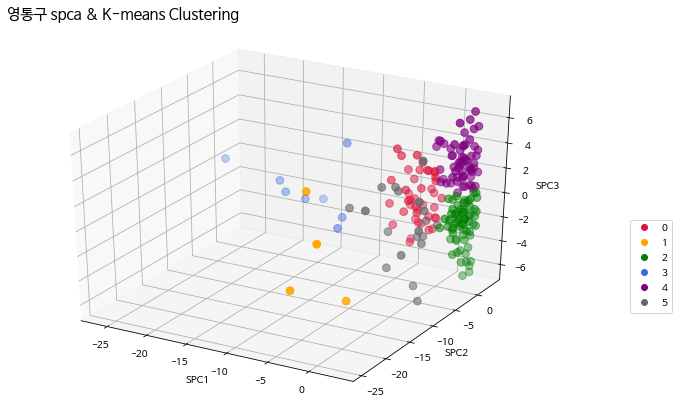

In [70]:
ClusteringPlot("영통구", 6, color_list)

In [71]:
# k-means group 
group0 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 0]
group1 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 1]
group2 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 2]
group3 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 3]
group4 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 4]
group5 = bus_kmeans_spca[bus_kmeans_spca["kmeans"] == 5]

group0.shape, group1.shape, group2.shape, group3.shape, group4.shape, group5.shape

((42, 142), (4, 142), (67, 142), (8, 142), (61, 142), (19, 142))

In [72]:
def groups6(columns) : 
    result = {}  
    
    for col in columns : 
        result[col] = [group0.mean()[col], group1.mean()[col], group2.mean()[col], 
                       group3.mean()[col], group4.mean()[col], group5.mean()[col]]
    
    result = pd.DataFrame(result)
    result.index = ["group0", "group1", "group2", "group3", "group4", "group5"]
    
    return result

In [73]:
'''
0 : (+) 초승_승차비율 / (-) 주중전체승하차건수, 전체 승차 건수, 주중대기시간노출도, 환승 건수, 운행노선수, 주중배차간격_15분
1 : (-) 유동인구_전체, 디지털정보지수, 유동인구_퇴근, 유동인구_출퇴근, pop_평일
2 : (+) 주말승차비율, 승차비율, 주중승차비율, 공휴일승차비율 / (-) 하차비율, 주말하차비율, 주중하차비율, 공휴일하차비율 

'''
spca_components.iloc[0].sort_values(ascending=False)

초승_승차비율               0.048527
nlp_9                 0.000000
강수량상관관계               0.000000
주말배차간격(분)             0.000000
주말승차비율                0.000000
주말하차비율                0.000000
주말배차간격_60분            0.000000
주말승차많은버스              0.000000
주말하차많은버스              0.000000
평균주말배차간격              0.000000
공휴일승차비율               0.000000
공휴일하차비율               0.000000
공휴일승차많은버스             0.000000
공휴일하차많은버스             0.000000
온도상관관계                0.000000
주중하차많은버스              0.000000
nlp_8                 0.000000
미세먼지(㎍/㎥)             0.000000
초미세먼지(㎍/㎥)            0.000000
오존(ppm)               0.000000
이산화질소(ppm)            0.000000
아황산가스(ppm)            0.000000
일산화탄소(ppm)            0.000000
500m내지하철역갯수           0.000000
지하철이용객                0.000000
미세_봄                  0.000000
미세_여름                 0.000000
평균주중배차간격              0.000000
주중승차많은버스              0.000000
미세_겨울                 0.000000
하차비율                  0.000000
LED                   0.000000
LCD     

                  df          sum_sq        mean_sq          F   PR(>F)
C(kmeans)   5.000000 28200284.521606 5640056.904321 124.625900 0.000000
Residual  195.000000  8824899.934042   45255.897098        nan      nan 



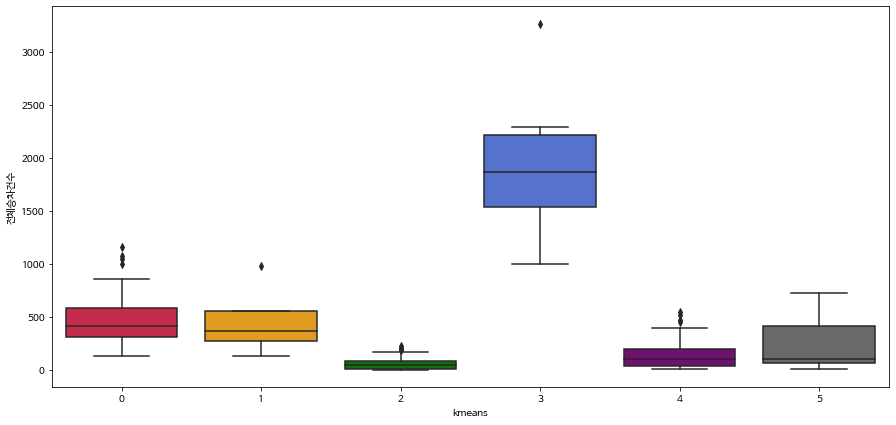

In [74]:
CompareGroups('전체승차건수', 6, color_list) 

                  df      sum_sq     mean_sq         F   PR(>F)
C(kmeans)   5.000000 6905.721318 1381.144264 63.187888 0.000000
Residual  195.000000 4262.258781   21.857737       nan      nan 



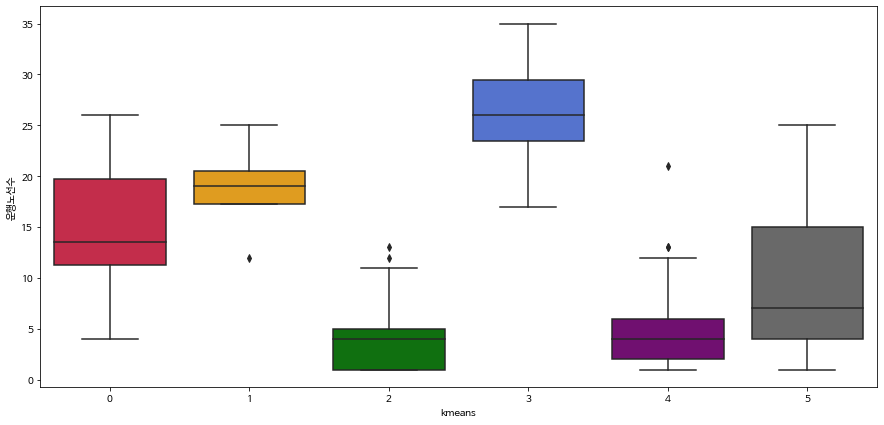

In [75]:
CompareGroups('운행노선수', 6, color_list) 

                  df        sum_sq      mean_sq          F   PR(>F)
C(kmeans)   5.000000 100645.686684 20129.137337 207.067229 0.000000
Residual  195.000000  18956.074325    97.210638        nan      nan 



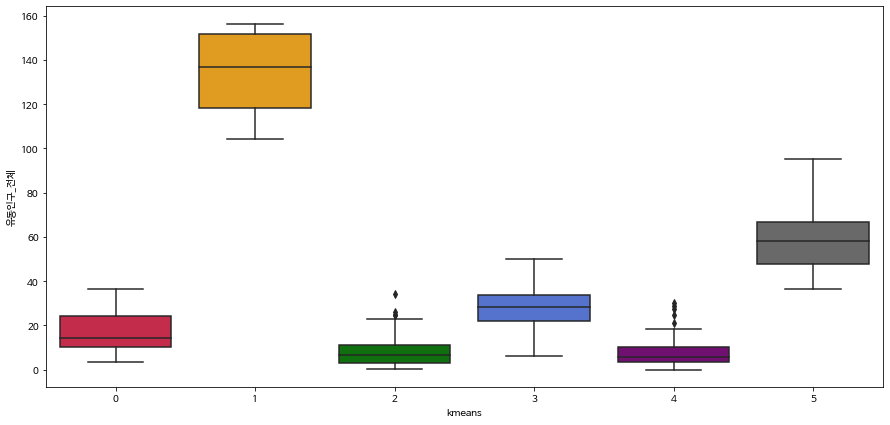

In [76]:
CompareGroups('유동인구_전체', 6, color_list) 

### 평균값을 통해 그룹 간의 차이 확인 

In [77]:
# PC1
groups6(['초승_승차비율', '주중전체승하차건수', '공휴일전체승하차건수', 
        '주말전체승하차건수', '주중대기시간노출도', '환승 건수', '운행노선수', '주중배차횟수'])


,초승_승차비율,주중전체승하차건수,공휴일전체승하차건수,주말전체승하차건수,주중대기시간노출도,환승 건수,운행노선수,주중배차횟수
group0,0.743159,1081.439399,516.881311,611.237415,8092.452344,104.312892,15.095238,842.264369
group1,0.761653,1032.083433,459.684828,526.449949,8107.254547,102.619178,18.750000,1014.386422
group2,0.895055,193.458262,82.424972,98.871144,980.062680,5.468619,3.985075,223.033317
group3,0.516566,4102.100328,2104.534600,2460.984611,33035.906848,946.193626,26.250000,1416.564620
group4,0.944256,249.322462,108.024290,127.193235,2537.092116,9.068750,4.983607,266.651311
group5,0.804111,582.233085,295.286438,351.345269,4086.828855,47.191896,9.631579,500.373258


In [78]:
# PC2 
groups6(['유동인구_전체', '디지털정보지수', '유동인구_퇴근', '유동인구_출퇴근', '여자40대유동인구', 'pop_평일'])

,유동인구_전체,디지털정보지수,유동인구_퇴근,유동인구_출퇴근,여자40대유동인구,pop_평일
group0,17.267649,198.164980,30.378981,25.917192,44.085774,429.499167
group1,133.495799,1646.079440,190.904444,179.157778,368.746250,3193.766625
group2,8.442706,99.950344,13.325535,11.921567,21.604142,217.019729
group3,27.512270,302.049388,47.710521,42.732674,62.538646,701.536625
group4,8.062596,94.730776,13.539904,11.626143,20.387773,203.663000
group5,60.564159,725.998046,92.324781,84.181140,151.108289,1518.979658


In [79]:
# PC3 
groups6(['주말승차비율', '승차비율', '주중승차비율', '공휴일승차비율', '하차비율', '주말하차비율', '주중하차비율', '공휴일하차비율'])

,주말승차비율,승차비율,주중승차비율,공휴일승차비율,하차비율,주말하차비율,주중하차비율,공휴일하차비율
group0,0.405538,0.398611,0.396581,0.404879,0.484461,0.483930,0.484632,0.485601
group1,0.395532,0.388656,0.386668,0.401056,0.486978,0.474857,0.489411,0.480781
group2,0.289258,0.296532,0.297771,0.284562,0.674366,0.682391,0.672772,0.674131
group3,0.286798,0.286454,0.286179,0.291054,0.460567,0.470418,0.457938,0.471805
group4,0.665415,0.654411,0.650551,0.675424,0.309431,0.300798,0.312633,0.292305
group5,0.387695,0.388737,0.388385,0.389156,0.531160,0.539287,0.529444,0.536330


## Result 
* target : **group3** (8개, 전체승하차건수 월등히 많고 버스 운행 노선 수도 많은 편) + **group1** (4개, 유동인구 많음) + **group5** (19개, 유동인구 두번째로 많음) 

In [80]:
bustarget_yt = pd.concat([bus_yt[['정류소ID','정류장명','lon','lat','위치(동)']].reset_index(drop=True), bus_kmeans_spca.reset_index(drop=True)], axis = 1)
bustarget_yt = pd.concat([bustarget_yt[bustarget_yt['kmeans']==3], bustarget_yt[bustarget_yt['kmeans']==1], bustarget_yt[bustarget_yt['kmeans']==5]]).reset_index(drop=True)
bustarget_yt.to_excel(current_path+'/busdata/bustarget_yt.xlsx', index = False)

print(bustarget_yt.shape)
bustarget_yt.head(2)

(31, 147)


,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체승차건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,kmeans,spca_component_1,spca_component_2,spca_component_3
0,202000005,아주대.아주대병원입구,127.043725,37.278619,경기도 수원시 원천동,1,1,0,0,0,0,25,1,2.465137,0.657431,0.952010,0.342569,0.701562,1.653572,0.252235,0.118265,0.629500,1575.815613,1060.155054,515.660559,1958.450404,0,0,0,14,0,7,0,1,7,18.833333,18.666667,31.357143,0.259450,0.118200,0.622350,4033.893416,7,3,1314.071656,0,1,7,23184.654032,45.000000,38.547619,0.226094,0.120802,0.653104,2489.114436,1,4,956.645261,0,1,6,17931.187465,65.000000,0.236945,0.108990,0.654065,2129.311111,0,1,6,15561.159722,-0.013031,0.016480,0.076836,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,1985,71,3,25500,355,570.020000,485.580000,3.680000,80.860000,64.935000,88.890000,33.090833,48.971667,54.232500,43.710833,19.537500,73.371667,105.375833,155.340000,88.110000,58.283333,18.745833,57.497500,58.063333,65.695000,42.591667,51.557500,886.643333,565.925417,362.358189,0,9,38,0,0.191489,0.808511,0.000000,0,0,9,46,7,5,0,0,0,0,0,0,0,0,1,0,3,-10.470705,-2.420053,-2.283320
1,203000068,구법원사거리,127.047218,37.273968,경기도 수원시 원천동,1,2,0,0,0,0,35,1,2.161969,0.616860,3.308256,0.383140,1.893175,5.201431,0.305555,0.202125,0.492320,1933.841126,1043.832644,890.008482,2600.885009,0,0,0,22,0,6,3,10,1,18.866667,19.250000,24.625000,0.304123,0.203131,0.492746,5263.284818,13,2,1898.499693,3,8,1,31834.639151,55.000000,30.285714,0.301140,0.200378,0.498481,3003.013535,7,3,1432.910403,2,8,0,25338.811401,72.500000,0.320597,0.191088,0.488315,2603.290850,4,7,0,21999.743464,-0.036833,0.068434,0.056724,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,1983,56,3,20000,352,1512.275000,1264.435000,17.380000,230.425000,99.028750,99.750000,35.423299,55.479583,51.394167,59.565000,17.080000,60.837500,92.015833,108.883333,112.003333,99.191667,16.230833,58.573333,64.141667,77.495833,76.095833,67.615000,905.955167,713.147917,377.161938,0,16,79,0,0.168421,0.831579,0.000000,0,0,5,12,0,3,0,1,0,0,0,0,0,0,0,0,3,-17.224682,-3.135272,-0.856008
